## Calculate the area and integrated concentration of the pool - EW_OBCS exp

The area of the pool is defined as the sum of area of the cells with anomaly of concentration higher than zero. Anomaly of concentration is the bottom concentration in the canyon case minus the no canyon case.

The area-weighted average concentration of the pool is defined as

$\Gamma =\frac{\sum_{i,j} C_{i,j}a_{i,j}}{\sum a_{i,j}}$

where $C_{i,j}$ is the concentration of the (i,j)th cell with anomaly of concentration higher than zero and $a_{i,j}$ is it's area.





In [2]:
#KRM

import numpy as np

import matplotlib.gridspec as gspec

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [3]:
# Seaborn set up
sns.set()
sns.set_style('white')
sns.set_context('notebook')

In [4]:
# Input files
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

CanyonState06='/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run06/stateGlob.nc'
CanyonStateOut06 = Dataset(CanyonState06)

Ptracer38='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
PtracerOut38 = Dataset(Ptracer38)

Ptracer42='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc'
PtracerOut42 = Dataset(Ptracer42)

Ptracer06='/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run06/ptracersGlob.nc'
PtracerOut06 = Dataset(Ptracer06)

Ptracer05='/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run05/ptracersGlob.nc'
PtracerOut05 = Dataset(Ptracer05)




In [5]:
# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [6]:
# Read in tracer fields
Tr38 = rout.getField(Ptracer38,'Tr1') # 
Tr06 = rout.getField(Ptracer06,'Tr1') # 

Tr42 = rout.getField(Ptracer42,'Tr1') # 
Tr05 = rout.getField(Ptracer05,'Tr1') # 

U06 = rout.getField(CanyonState06,'U')
U38 = rout.getField(CanyonState,'U')

In [7]:
def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr:tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = concentration at cell closest to bottom(nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

In [8]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Anomaly in tracer field (canyon - no canyon )(nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((19,360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [9]:
ConcArea38,  Conc38Filt, Area38 = ConcAreaPool(Tr38-Tr42, hFacC, rA, bathy)
ConcArea06,  Conc06Filt, Area06 = ConcAreaPool(Tr06-Tr05, hFacC, rA, bathy)


(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)
(360, 360)
(19, 360, 360)


In [10]:
Conc42FiltSq, Area42Sq = ConcArea(Tr42, hFacC, rA, bathy)
Conc05FiltSq, Area05Sq = ConcArea(Tr05, hFacC, rA, bathy)


(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)


### Anomalies with respect to base case

In [11]:
def plot_pool(fig,data,depths,tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'Purples',fill_col='SlateBlue' ):
    '''
    INPUT:
    fig: figure object
    data: 3d slice of output (np. array with t,y,x dimensions)
    depths: 2d array bathymetry, same size as data.
    tt: time index
    x_2d: 2d array of xc
    y_2d: 2d array of yc
    x_vect: 1d array of xc
    y_vect: 1d array of yc
    maxCM: max value for contourf colormap
    minCM: min value for contourf colormap
    cmap: string with the name of the colormap to use. Default is 'Purples'.
    fill_col: string with fill color for marginal line plots. Default is 'SlateBlue'.
    
    
    '''

    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    xmin = x_vect.min()
    xmax = x_vect.max()
    ymin = y_vect.min()
    ymax = y_vect.max()

    #Set style to white
    sns.set_style('white')

    #Define grid for subplots
    gs = gspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])

    #Create contour plot
    ax = plt.subplot(gs[1,0])
    caxf = ax.contourf(x_2d,y_2d,data,45, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    bax = ax.contour(x_2d,y_2d,depths,[60,80,100,120,147.5], colors = '0.5')
    plt.clabel(bax, inline=1, fontsize=13)
    
    cax = ax.contour(x_2d,y_2d,data,7,colors = 'k')
    plt.clabel(cax, inline=1, fontsize=13)

    ax.set_xlabel('Alongshore distance [km]')
    ax.set_ylabel('Cross-shore distance [km]')

    #Turn on all axes
    ax.axis('on')

    #Create Y-marginal (right)
    axr = plt.subplot(gs[1,1], frameon = True,yticks=[],xlim=(data_mean_y.min(), data_mean_y.max()), ylim=(ymin, ymax) )
    axr.plot(data_mean_y, y_vect, color = 'black')
    axr.fill_betweenx(y_vect, 0, data_mean_y, alpha = .75, color = fill_col )
    axr.set_xlabel('mean BAC [(Mol/l)/m]')

    #Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = True, xticks=[], xlim = (xmin, xmax), ylim=(data_mean_x.min(), data_mean_x.max()))
    axt.plot(x_vect, data_mean_x, color = 'black')
    axt.fill_betweenx(data_mean_x, 0, x_vect, alpha = .75, color = fill_col)
    
    TEXT_OBJ = ax.text(1.1, 1.45, ('Day %1.1f ' %(tt/2.0)), transform=ax.transAxes, fontsize=20)
    
    #Bring the marginals closer to the contour plot
    fig.tight_layout(pad = 1)
    

Run 38 minus no canyon case


/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


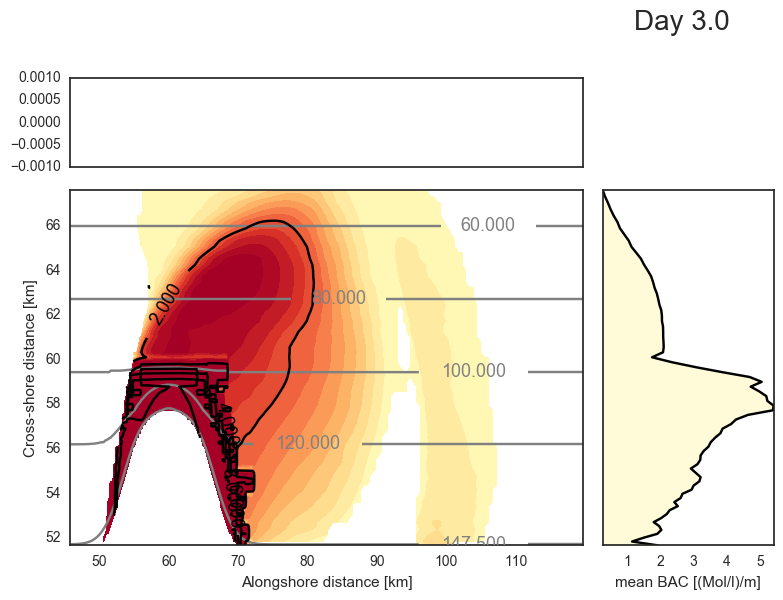

In [12]:
print('Run 38 minus no canyon case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc38Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 38 minus no canyon case


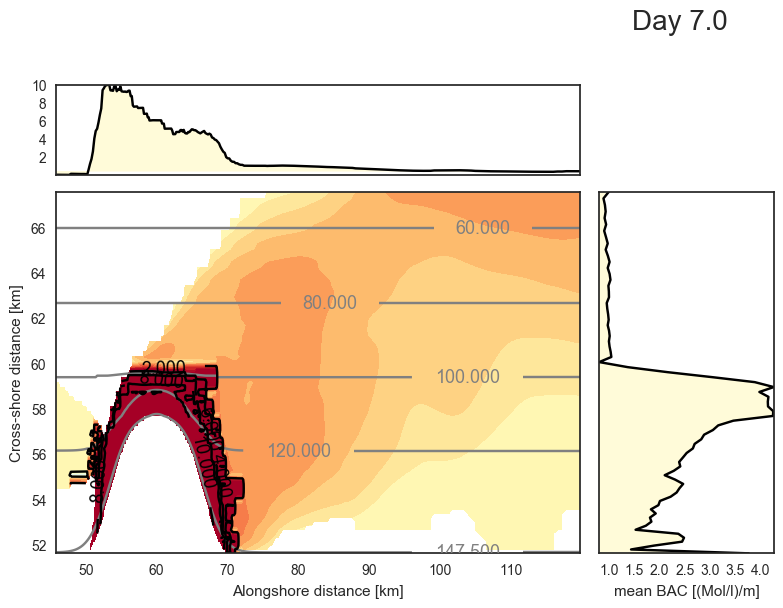

In [13]:
print('Run 38 minus no canyon case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc38Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 06 minus no canyon case


/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


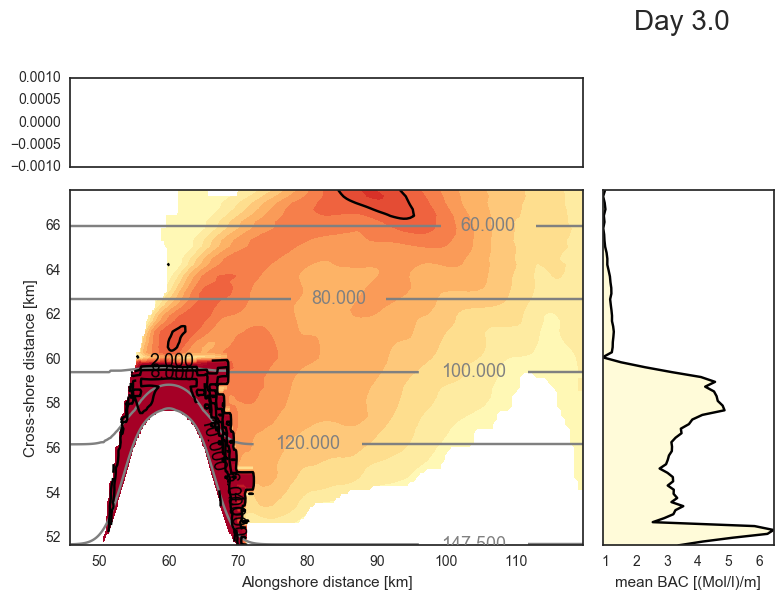

In [14]:
print('Run 06 minus no canyon case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc06Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 06 minus noC case


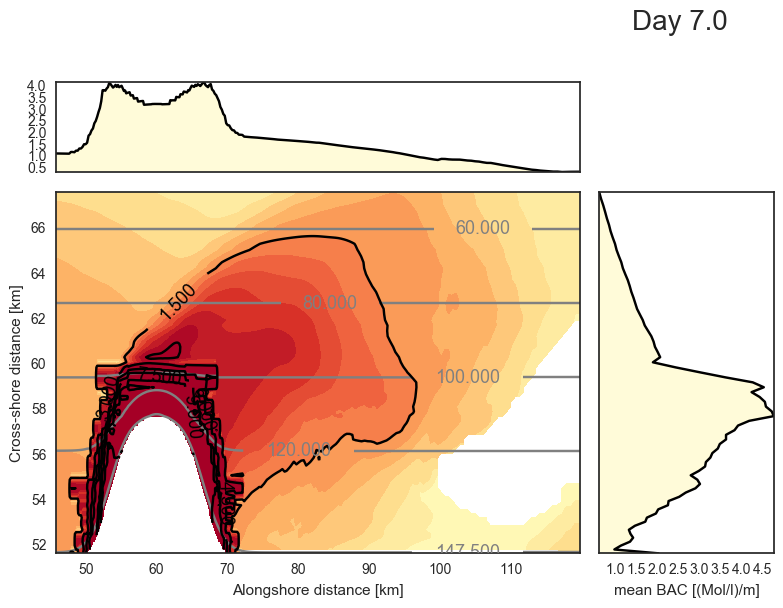

In [15]:
print('Run 06 minus noC case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc06Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Anomalies


/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


[]

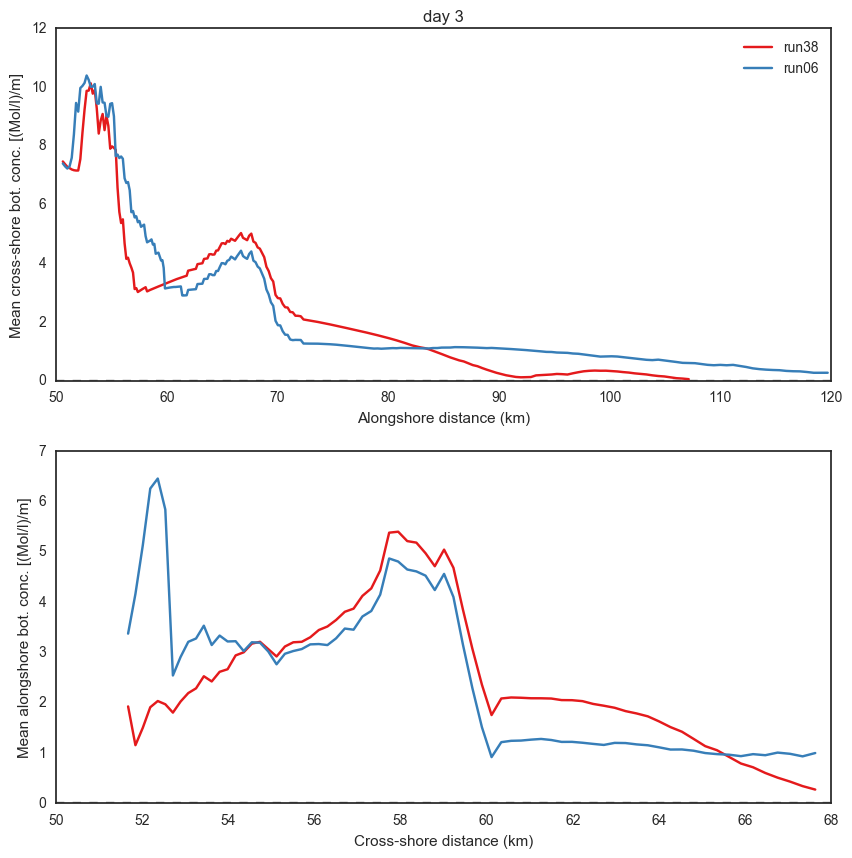

In [16]:
sns.set_palette('Set1',8)

print('Anomalies')
labels = ['run38','run06']

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

tt=6
data_sets = [Conc38Filt[tt,227:300,100:],
             Conc06Filt[tt,227:300,100:],
            ]

fig,ax = plt.subplots(2,1,figsize=(10,10))

for data,lab in zip(data_sets,labels):
    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    ax[0].plot(x_vect,data_mean_x,label = lab)
    ax[1].plot(y_vect,data_mean_y,label = lab)

ax[0].axhline(0, color='0.5', linestyle = '--')
ax[1].axhline(0, color='0.5', linestyle = '--')

ax[0].set_ylabel('Mean cross-shore bot. conc. [(Mol/l)/m]')
ax[1].set_ylabel('Mean alongshore bot. conc. [(Mol/l)/m]')
ax[0].set_xlabel('Alongshore distance (km)')
ax[1].set_xlabel('Cross-shore distance (km)')
ax[0].set_title('day 3')
ax[0].legend(loc=0)
plt.plot()

Anomalies


[]

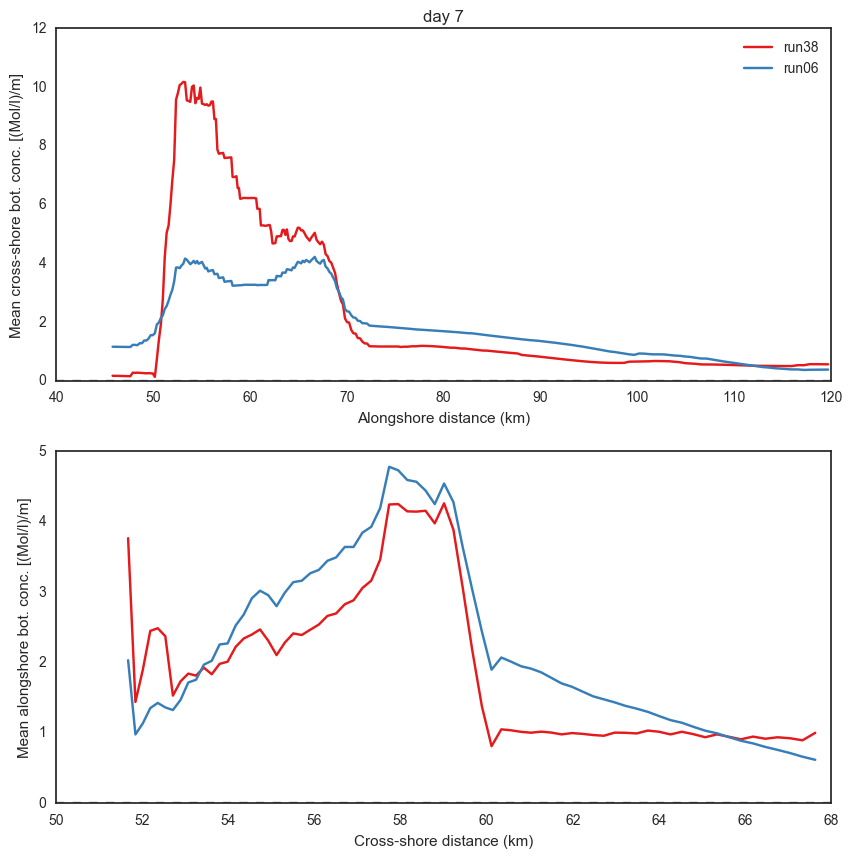

In [17]:
print('Anomalies')
labels = ['run38','run06']

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

tt=14
data_sets = [Conc38Filt[tt,227:300,100:],
             Conc06Filt[tt,227:300,100:],
             ]


fig,ax = plt.subplots(2,1,figsize=(10,10))

for data,lab in zip(data_sets,labels):
    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    ax[0].plot(x_vect,data_mean_x,label = lab)
    ax[1].plot(y_vect,data_mean_y,label = lab)

ax[0].axhline(0, color='0.5', linestyle = '--')
ax[1].axhline(0, color='0.5', linestyle = '--')

ax[0].set_ylabel('Mean cross-shore bot. conc. [(Mol/l)/m]')
ax[1].set_ylabel('Mean alongshore bot. conc. [(Mol/l)/m]')
ax[0].set_xlabel('Alongshore distance (km)')
ax[1].set_xlabel('Cross-shore distance (km)')
ax[0].set_title('day 7')
ax[0].legend(loc=0)
plt.plot()

[]

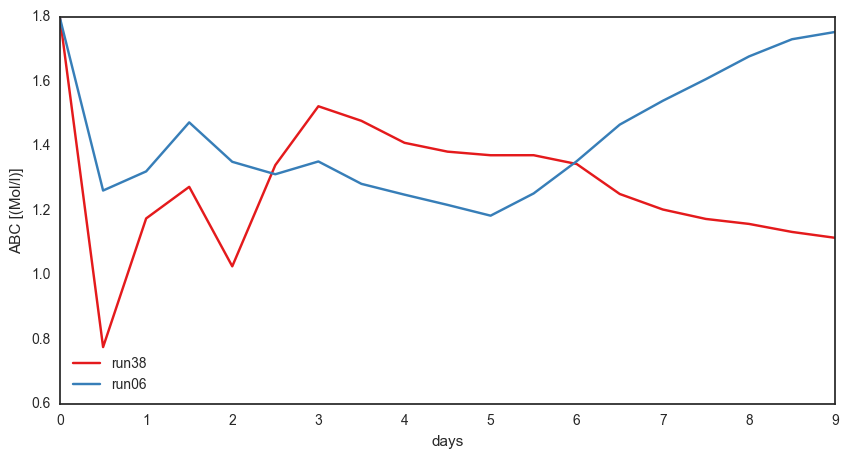

In [18]:
print('')
labels = ['run38','run06']
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Conc38Filt[:,227:300,100:]*Area38[:,227:300,100:],axis=1),axis=1)/
             (np.nansum(np.nansum(Area38[:,227:300,100:],axis=1),axis=1)),
            np.nansum(np.nansum(Conc06Filt[:,227:300,100:]*Area06[:,227:300,100:],axis=1),axis=1)/
             (np.nansum(np.nansum(Area06[:,227:300,100:],axis=1),axis=1)),
            ]

    
fig,ax = plt.subplots(1,1,figsize=(10,5))

for data,lab in zip(data_sets,labels):
    
    ax.plot(np.arange(19)/2.0,data,label = lab)
    
#ax.axhline(0, color='0.5', linestyle = '--')

ax.set_ylabel('ABC [(Mol/l)]')
ax.set_xlabel('days')
ax.set_xlabel('days')

ax.legend(loc=0)
plt.plot()

[]

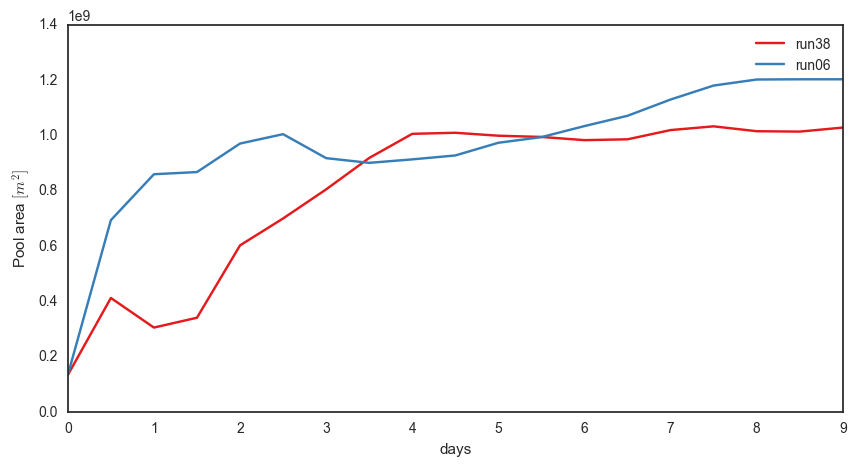

In [19]:
print('')
labels = ['run38','run06']

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Area38[:,227:300,100:],axis=1),axis=1),
            np.nansum(np.nansum(Area06[:,227:300,100:],axis=1),axis=1),
            ]

    
fig,ax = plt.subplots(1,1,figsize=(10,5))

for data,lab in zip(data_sets,labels):
    
    ax.plot(np.arange(19)/2.0,data,label = lab)
    
#ax.axhline(0, color='0.5', linestyle = '--')

ax.set_ylabel('Pool area $[m^2]$')
ax.set_xlabel('days')

ax.legend(loc=0)
plt.plot()

[]

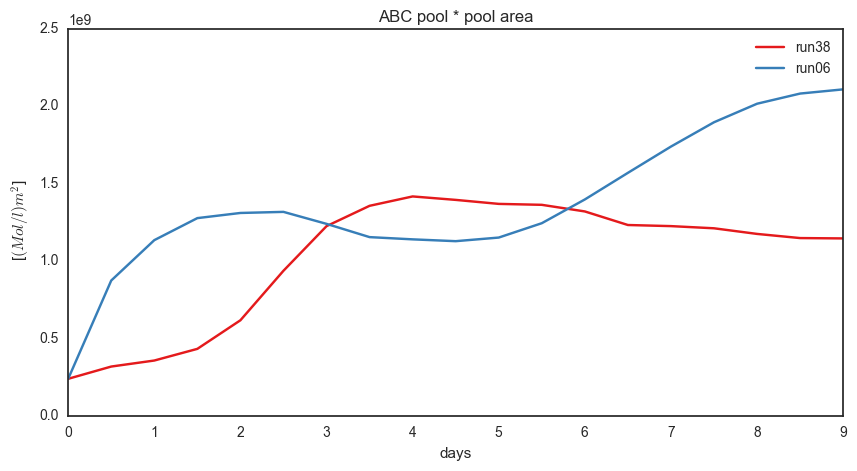

In [20]:
print('')
labels = ['run38','run06']
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Conc38Filt[:,227:300,100:]*Area38[:,227:300,100:],axis=1),axis=1),
            np.nansum(np.nansum(Conc06Filt[:,227:300,100:]*Area06[:,227:300,100:],axis=1),axis=1),
            ]

    
fig,ax = plt.subplots(1,1,figsize=(10,5))

for data,lab in zip(data_sets,labels):
    
    ax.plot(np.arange(19)/2.0,data,label = lab)
    
#ax.axhline(0, color='0.5', linestyle = '--')

ax.set_ylabel(' [$(Mol/l)m^2$]')
ax.set_xlabel('days')
ax.set_title('ABC pool * pool area')

ax.legend(loc=0)
plt.plot()

[]

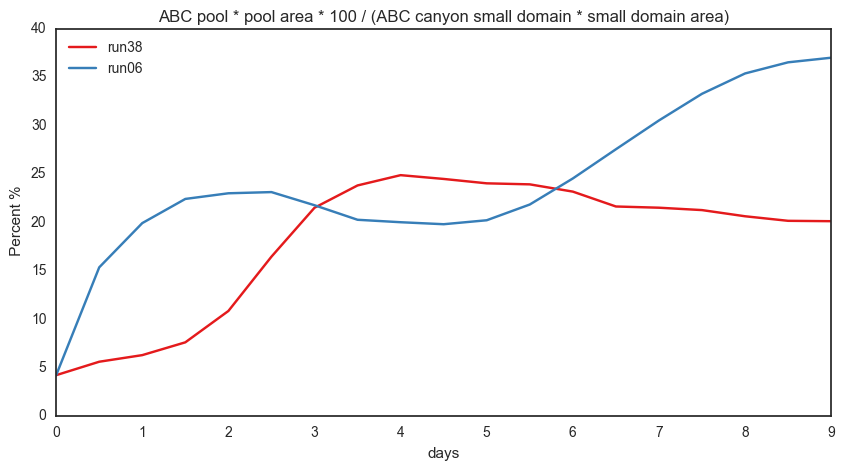

In [21]:
sns.set_palette('Set1',8)

print('')
labels = ['run38','run06']
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Conc38Filt[:,227:300,100:]*Area38[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc42FiltSq[0,227:300,100:]*Area42Sq[227:300,100:]),
            np.nansum(np.nansum(Conc06Filt[:,227:300,100:]*Area06[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc05FiltSq[0,227:300,100:]*Area05Sq[227:300,100:]),
            ]

    
fig,ax = plt.subplots(1,1,figsize=(10,5))

for data,lab in zip(data_sets,labels):
    
    ax.plot(np.arange(19)/2.0,data,label = lab)
    
#ax.axhline(0, color='0.5', linestyle = '--')

ax.set_ylabel(' Percent %')
ax.set_xlabel('days')
ax.set_title('ABC pool * pool area * 100 / (ABC canyon small domain * small domain area)')

ax.legend(loc=0)
plt.plot()


Mean u for base case is (m$s^-1$) 0.295236
Mean u for run06 is (m$s^-1$) 0.362118


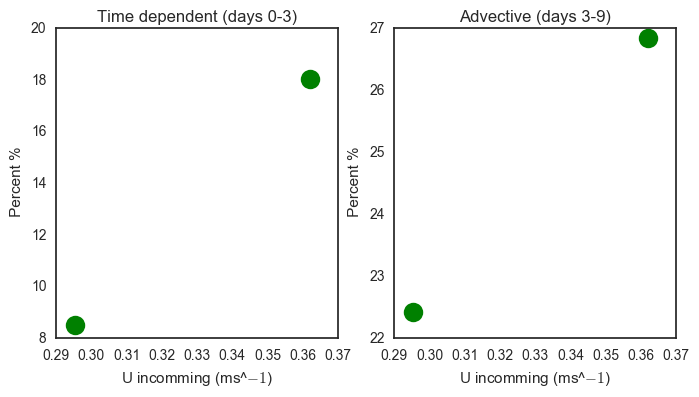

In [23]:
sns.set_palette('Set1',8)

print('')
labels = ['run38','run06']


UIn38 = np.nanmean(U38[:,24:26,225:229,120])
UIn06 = np.nanmean(U06[:,24:26,225:229,120])

print('Mean u for base case is (m$s^-1$)', UIn38 )
print('Mean u for run06 is (m$s^-1$)', UIn06 )

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Conc38Filt[:,227:300,100:]*Area38[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc42FiltSq[0,227:300,100:]*Area42Sq[227:300,100:]),
            np.nansum(np.nansum(Conc06Filt[:,227:300,100:]*Area06[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc05FiltSq[0,227:300,100:]*Area05Sq[227:300,100:]),
            ]

UIn_vec = [UIn38,UIn06]
fig,ax = plt.subplots(1,2,figsize=(8,4))

for data,lab,u_num in zip(data_sets,labels,UIn_vec):
    
    ax[0].plot(u_num,np.nanmean(data[:6]),'go',markersize=14,label = lab)
    ax[1].plot(u_num,np.nanmean(data[6:]),'go',markersize=14,label = lab)
    
ax[0].set_ylabel(' Percent %')
ax[0].set_xlabel('U incomming (ms^${-1}$)')
ax[0].set_title('Time dependent (days 0-3)')

ax[1].set_ylabel(' Percent %')
ax[1].set_xlabel('U incomming (ms^${-1}$)')
ax[1].set_title('Advective (days 3-9)')



fig.savefig('pool_impact_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


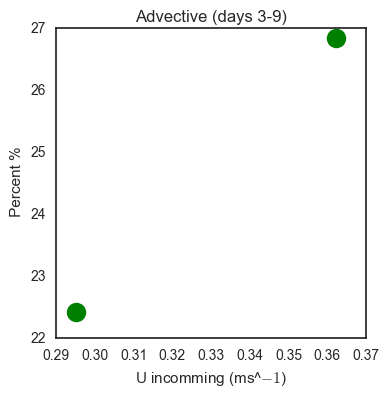

In [24]:
sns.set_palette('Set1',8)
sns.set_context('notebook')
print('')
labels = ['run38','run06']


y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [np.nansum(np.nansum(Conc38Filt[:,227:300,100:]*Area38[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc42FiltSq[0,227:300,100:]*Area42Sq[227:300,100:]),
            np.nansum(np.nansum(Conc06Filt[:,227:300,100:]*Area06[:,227:300,100:],axis=1),axis=1)*100.0/
            np.nansum(Conc05FiltSq[0,227:300,100:]*Area05Sq[227:300,100:]),
            ]

    
fig,ax = plt.subplots(1,1,figsize=(4,4))

for data,lab,u_num in zip(data_sets,labels,UIn_vec):
    
    ax.plot(u_num,np.nanmean(data[6:]),'go',markersize=14,label = lab)
    
ax.set_ylabel(' Percent %')
ax.set_xlabel('U incomming (ms^${-1}$)')

ax.set_title('Advective (days 3-9)')

#ax[1].legend(loc=3)



fig.savefig('pool_impact_forcing_adv_phase.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


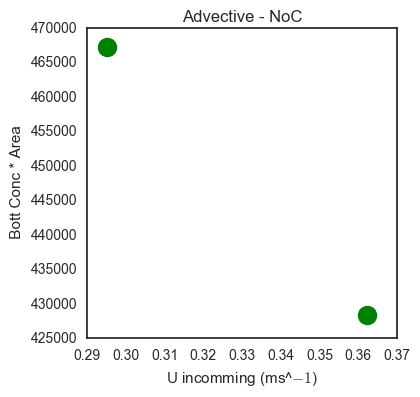

In [25]:
sns.set_palette('Set1',8)
sns.set_context('notebook')
print('')
labels = ['run38','run06','run45','run46','run51','run52']


y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [Conc42FiltSq[:,227:300,100:]*Area42Sq[227:300,100:],
             Conc05FiltSq[:,227:300,100:]*Area05Sq[227:300,100:],
             ]

    
fig,ax = plt.subplots(1,1,figsize=(4,4))

for data,lab,u_num in zip(data_sets,labels,UIn_vec):
    
    ax.plot(u_num,np.nanmean(data[6:]),'go',markersize=14,label = lab)
    
ax.set_ylabel(' Bott Conc * Area')
ax.set_xlabel('U incomming (ms^${-1}$)')

ax.set_title('Advective - NoC')

#ax[1].legend(loc=3)

plt.plot()

fig.savefig('BAC_NoC_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


In [26]:
Conc38FiltSq, Area38Sq = ConcArea(Tr38, hFacC, rA, bathy)
Conc06FiltSq, Area06Sq = ConcArea(Tr06, hFacC, rA, bathy)


(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)


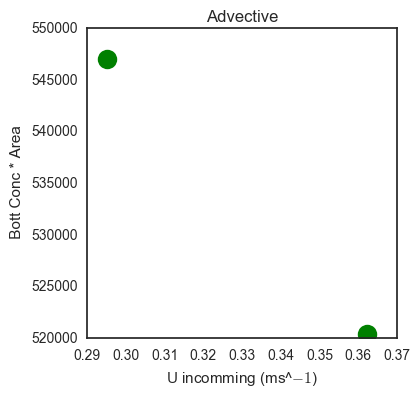

In [27]:
sns.set_palette('Set1',8)
sns.set_context('notebook')
print('')
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0


data_sets = [Conc38FiltSq[:,227:300,100:]*Area38Sq[227:300,100:],
             Conc06FiltSq[:,227:300,100:]*Area06Sq[227:300,100:],
             ]

    
fig,ax = plt.subplots(1,1,figsize=(4,4))

for data,lab,u_num in zip(data_sets,labels,UIn_vec):
    
    ax.plot(u_num,np.nanmean(data[6:]),'go',markersize=14,label = lab)
    
ax.set_ylabel(' Bott Conc * Area')
ax.set_xlabel('U incomming (ms^${-1}$)')

ax.set_title('Advective')

#ax[1].legend(loc=3)

plt.plot()

fig.savefig('BAC_cany_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')
